# <u><b>0 - Préambule au code</b></u>

## <b><u>0.1 - Ensemble des variables à modifier en début d'exécution du Notebook :</u></b>
!!! On attire l'attention du lecteur/utilisateur sur les variables ci dessous :
- <b>Les chemins d'accès de données :</b> Ils sont définis localement, et depuis peu de façon relative au répertoire contenant ce notebook. Le lecteur/utilisateur est libre de les modifier par rapport à son propre environnement, mais il faudra alors veiller à rendre cette modification cohérence avec le bon accès aux fichiers présents ci-dessous dans les répertoires <b>../Cache_fichiers/</b>, <b>../Figures/</b>, etc.
- <b>Les booléens d'activation/désactivation :</b> Attention, ces booléens (selon qu'ils prennent True ou False) activent (ou désactivent) des fonctions telles que la sauvegarde en local de fichiers créés à partir de données calculées dans ce notebook, la sauvegarde en local de figures, etc.
- <b>Le booléen<i>avec colab</i> :</b> A passer sur True si on utilise le notebook depuis google colab pour qu'il puisse se connecter au drive et avoir accès aux données qui y sont stockées
- <b>La variable <i>dossiers_b2d_chiens</i> :</b> Permet de choisir entre l'une des deux base de données (13 races et 28 races, respectivement).

In [1]:
# Booléen prioritaire : on exécute le notebook avec Google Collab, vari ou faux !!!
avec_colab = False
if avec_colab :
    from google.colab import drive
    drive.mount('/content/drive/')
# Jeu de données sur lequel on travaille
dossiers_b2d_chiens = [
    "150_dogs_per_race/", 
    "150_dogs_per_race+/"
][1]

In [2]:
# Booléen d'activation (ou non) de l'installation des modules/librairies nécessaires au bon fonctionnement de ce Notebook (cf partie 1.1) du Notebook).
installation = False

### Tout ce qui concerne la base de données
# Chemin de données vers la base de données
if avec_colab:
    #"/content/drive/My Drive/P6/B2D/Images/"
    path_b2d = "/content/drive/My Drive/P7/Notebook/"+dossiers_b2d_chiens
else :
    #"C:/Users/luked/Documents/Formation_Ingenieur_ML/Projets/P6/B2D/
    #"dogs_standford_dataset"
    #"../../../P6/B2D/Images/"
    path_b2d = dossiers_b2d_chiens
    
### Tout ce qui concerne les figures
# Sauvegarde des figures 
sauvegarde_figure = True 
if sauvegarde_figure :
    prefixe = dossiers_b2d_chiens[:-1]+'_'
    # chemin de données vers répertoire de stockage
    if avec_colab :
        path_fig = "/content/drive/My Drive/P7/Figures/"+prefixe
    else :
        path_fig = "../Figures/"+prefixe

### Tout ce qui concerne le cache des fichiers (pour ne pas avoir à refaire tous les calculs systématiquement)
# Sauvegarde des figures 
sauvegarde_fichiers = True 
if sauvegarde_fichiers :
    prefixe = dossiers_b2d_chiens[:-1]+'_'
    # Chemin de données vers répertoire de stockage
    if avec_colab :
        path_cache_output = "/content/drive/My Drive/P7/Cache_fichiers/"+prefixe
    else :
        path_cache_output = "../Cache_fichiers/"+prefixe

### Autres
# Booléens d'activation de la mise de côté des calculs longs, au profit du chargement des résultats de ces calculs, préalablement sauvegardés en local
court_circuiter = True

## <u><b>0.2 - Installation éventuelle de librairies python :</b></u>
!!! Sautez cette étape si vous les avez déjà sur votre ordinateur, en mettant le booléen <i>installation</i> à <i>False</i>.

In [3]:
if installation :
    !pip install Pillow
    !pip install transformers
    !pip install tensorflow

## <u><b>0.3 - Importations de librairies/modules/fonctions python :</b></u>

In [4]:
import os
### Quelques classiques des notebooks scientifiques
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
### Traitement de texe
from re import split
### Mesure du temps
from tqdm import tqdm
from time import time
### Pickle
import pickle

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [6]:
### Keras
from tensorflow.keras.utils import image_dataset_from_directory, set_random_seed
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy

In [7]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocin_mobnet2

## <u><b>0.4 - Définition de constantes personnelles :</b></u>

In [8]:
### On détermine un entier qui servira à gêler le random state au sein des différentes fonctions
rgn = 420

In [9]:
### On bloque le hasrd de numpy et de tensorflow.keras
np.random.seed(rgn)
set_random_seed(rgn)

In [10]:
# Liste des répertoires nommés selon le schéma "identifiant_chien"
list_dir = np.asarray(os.listdir(path=path_b2d))# + 'Images'))
# Dictionnaire qui associe [identifiant, chien] à chaque indice de la liste des répertoire
n_idchiens = {
    n: split(string=list_dir[n], pattern='-') for n in range(len(list_dir))
}

In [11]:
# Liste des étiquettes de chaque image (sous forme de labels)
img_class_labels = [
    n_idchiens[n][1] for n in range(len(list_dir))
]

## <u><b>0.5 - Définition de fonctions personnelles :</b></u>

Les 3 fonctions ci-dessous ne sont pas de moi, je ne me les approprie pas ! Elles viennent d'une discussion publique sur <i>Stackoverflow</i> (https://stackoverflow.com/questions/51125266/how-do-i-split-tensorflow-datasets), et servent lors de la re-spération du <i>data set</i> en jeux d'entraînement et de test, lors de la section consacrée à la construction de notre propre CNN.

In [12]:
def is_test(x, y):
    """Fonction qui renvoit un booléen True si son entrée x est un multiple de 4.
    Elle prend deux arguments car x,y = enumerate(dataset), par anticipation de la façon dont est écrit le code en section III.

    Arguments de cette fonction :
    x -- entier, issu de la fonction enumerate
    y -- objet python en train d'être enumérer"""
    return x % 4 == 0
###
def is_train(x, y):
    """Fonction qui renvoit un booléen True si son entrée x n'est pas un multiple de 4. 
    Elle prend deux arguments car x,y = enumerate(dataset), par anticipation de la façon dont est écrit le code en section III.

    Arguments de cette fonction :
    x -- entier, issu de la fonction enumerate
    y -- objet python en train d'être enumérer"""
    return not is_test(x, y)
### Fonction lambda adaptée à la restitution d'un dataset après affectation à l'un des deux jeux de test ou d'entraînement grâce aux fonctions ci-dessus
recover = lambda x,y: y

In [13]:
def model_fit(X_train, X_val, model_compile, nb_epochs, num_verbose, tab_callbacks):
    """Fonction qui réalise le fitting d'un objet de type Sequential ou Model du module keras de la librairie tensorflow, et mesure la durée de cet entraînement.

    Arguments de cette fonction :
    X_train -- dataset correspondant au jeu d'entraînement
    X_val -- dataset correspondant au jeu de validation
    model_compile -- objet de type Sequential ou Model, précédemment compilé
    nb_epochs -- entier, nombre d'itération -epoch- à faire lors de l'entraînement
    num_verbose -- entier, valeur de l'hyper-paramètre verbose de la fonction fit qui gère l'affichage de la progression de l'entraînement
    tab_callbacks -- liste d'objet de type Callback du module keras de la librairie tensorflow"""
    # Initialisatin de la mesure du temps
    t0 = time()
    # Entraînement/validation croisée
    modele_info = model_compile.fit(X_train, epochs=nb_epochs, validation_data=X_val, verbose=num_verbose, callbacks=tab_callbacks)
    # Mesure du temps d'entraînement
    delta_t = time()-t0
    print(f'Temps d`entraînement : {delta_t : >.1f} secondes')
    return model_compile, modele_info, delta_t

In [14]:
def plot_loss_score(model_info, model_eff, tab_X_test, tab_label, titre):
    """Fonction qui réalise l'affichage graphique de l'évolution temporelle de la fonction de perte, et du score de précision, lors de l'entraînement.

    Arguments de cette fonction :
    model_info -- objet de type Sequential ou Model, défini comme un modele précédemment compilé et entraîné (model_info = model_eff.fit()), permettant l'accès à un historique
    model_eff-- objet de type Sequential ou Model précédemment compilé et entraîné
    tab_X_test -- liste de datasets correspondant à des de jeux de test
    tab_label -- liste de labels correspondant à ces jeux de test
    titre -- chaîne de caractère, titre du graphe"""
    ### Varibales adaptées aux performances sur les différents jeux
    # une liste de tableaux de performances sur les jeux de test, et mesure du temps nécessaire
    t0 = time()
    perf_test = [model_eff.evaluate(X_test) for X_test in tab_X_test] #[model_eff.evaluate(X_test, y_test) for (X_test, y_test) in zip(tab_X_test, tab_y_test)] 
    delta_t = time()-t0
    print(f'Temps d`évaluation : {delta_t : >.1f} secondes')
    # un dictionnaire de l'historique sur validation, la liste des métriques, et la liste des itérations
    dico, metric, epoch = model_info.history, model_info.model.metrics_names, model_info.epoch
    ### Graphe
    plt.figure('Performances '+titre, figsize=(7*len(metric), 7)), plt.clf()
    for i in range(0, len(metric)):
        axe = plt.subplot(1, len(metric), i+1)
        # metric n° i = f(epochs)
        axe.set_title(titre+f'\n{metric[i]} = f(Epochs)', fontsize=15, fontweight='bold') 
        axe.set_ylabel(metric[i], fontsize=12), axe.set_xlabel('Epochs', fontsize=12)
        axe.plot(epoch, dico[metric[i]], label='train set')
        axe.plot(epoch, dico['val_'+metric[i]], label='val set')
        # On complète avec les perf de la métrique courante sur les jeux de test
        for perf, label in zip(perf_test, tab_label):
            axe.plot([epoch[-1]+1], perf[i], marker='+', markersize=15, label=label+'test set')
        # Legendes
        axe.legend(loc='best')
    return perf_test[0], delta_t

In [15]:
def pickle_save(object_to_save, suffix_title):
    """Fonction qui sauvegarde un objet en local grâce à des fonctions de la librairie pickle

    Arguments de cette fonction :
    object_to_save -- objet python à sauver
    suffix_title -- chaîne de caractère, titre de la sauvegarde en local, nécessite que la variable de chemin de données path_cache_output ait été définie avant"""
    # on ouvre le mode écriture de l'objet à sauvegarder dans le répertoire pointé par abs_path_cache_output
    file_pickel_ab = open(file=path_cache_output+suffix_title,mode='wb')
    # sauvegarde effective
    pickle.dump(object_to_save, file_pickel_ab)
    # fermeture du mode écriture
    file_pickel_ab.close()
    del file_pickel_ab

In [16]:
def pickle_load(suffix_title):
    """Fonction qui charge un objet sauvegardé localement, grâce à des fonctions de la librairie pickle

    Arguments de cette fonction :
    suffix_title -- chaîne de caractère, titre de la sauvegarde en local, nécessite que la variable de chemin de données path_cache_output ait été définie avant"""
    # on ouvre le mode lecture de l'objet rangé dans le répertoire pointé par abs_path_cache_output
    file_pickel_rb = open(file=path_cache_output+suffix_title,mode='rb')
    # chargement effectif
    objet = pickle.load(file_pickel_rb)
    # fermeture du mode lecture
    file_pickel_rb.close()
    del file_pickel_rb
    return objet

In [17]:
def dict_model(model_info, tps_info, model_eval, tps_eval, nb_train_param, model_title):
    """Fonction qui crée un dictionnaire analogue à l'historique d'un Sequential/Model déjà entraîné

    Arguments de cette fonction :
    model_info -- objet de type Sequential ou Model, défini comme un modele précédemment compilé et entraîné, permettant l'accès à un historique
    tps_info -- durée de l'entraînement
    model_eval-- objet de type Sequential ou Model précédemment compilé et entraîné et après avoir subbit une évaluation
    tps_eval -- durée de l'évaluation
    tab_label -- liste de labels correspondant à ces jeux de test
    model_title -- chaîne de caractère, titre sous lequel on veut sauvegarder le modèle"""
    model_dict = {key : model_info.history[key] for key in model_info.history.keys()}
    model_dict['test_loss'], model_dict['test_accuracy'], model_dict['test_top-3-accuracy'] = model_eval[0], model_eval[1], model_eval[2]
    model_dict['train_time'], model_dict['test_time'], model_dict['nb_train_param'] = tps_info, tps_eval, nb_train_param
    if sauvegarde_fichiers :
        pickle_save(object_to_save=model_dict, suffix_title=model_title)

# <u><b>II - <i>Baseline</i></b></u>

## <u><b>II.A - Les données de travail</b></u>

### <u><b>II.A.1 - Chargement des données</b></u>

In [18]:
### Chargement des données sous la forme d'un tf.data.Dataset
# initilisation de mesure du temps
t0 = time()
# Chargement effectif
all_dataset = image_dataset_from_directory(
    directory=path_b2d, 
    label_mode='int',
    batch_size=None,#
    image_size=(224, 224), 
    shuffle=False,
    seed=rgn
)
# affichage du temps de cahrgrment
print(f'Dataset train chargé en {time()-t0 : .1f} secondes.')
del t0

Found 4200 files belonging to 28 classes.
Dataset train chargé en  2.1 secondes.


### <u><b>II.A.2 - Séparation en jeux d'entraînement, de test et de validation</b></u>

#### <u><b>a) Séparation en jeux d'entraînement, et de test</b></u>

On utilise pour cela les fonctions <i>is_test</i> et <i>is_train</i> définies plus haut, qui permettent d'ailleurs de respecter exactement la même répartition des images entre ces deux jeux que celle effectuée pour le modèle issu de ViT.

In [19]:
test_dataset = all_dataset.enumerate().filter(is_test).map(recover)
train_dataset = all_dataset.enumerate().filter(is_train).map(recover)

#### <u><b>b) Extraction du jeu de validation à partir du jeu d'entraînement (et régénartion de celui-ci)</b></u>

In [20]:
valid_dataset = train_dataset.enumerate().filter(is_test).map(recover)
train_dataset = train_dataset.enumerate().filter(is_train).map(recover)

## <u><b>II.B - Pré-traitements</b></u>

### <u><b>II.B.1 - Sans modification de l'histogramme des pixels des images</b></u>

#### <u><b>a) Mélanges (<i>shuffle</i>) des jeux</b></u>

Il faut mélanger aléatoirement les images au sein des jeux, afin d'éviter que ne soient à l'algorithme des séries entières d'images successives apparetant à la même classe (cela pourrait avoir un impact important sur l'apprentissage des poids et epêcher l'algorithme de bien apprendre/généraliser).

In [21]:
nb_races_train, train_size = len(np.unique([elem[1] for elem in train_dataset.as_numpy_iterator()])), len([elem[1] for elem in train_dataset.as_numpy_iterator()])
print(f'Le jeu d`entraînement est composé de {train_size : >6.0f} images issues de {nb_races_train : >3.0f} races différentes.')
nb_races_valid, valid_size = len(np.unique([elem[1] for elem in valid_dataset.as_numpy_iterator()])), len([elem[1] for elem in valid_dataset.as_numpy_iterator()])
print(f'Le jeu d`entraînement est composé de {valid_size : >6.0f} images issues de {nb_races_valid : >3.0f} races différentes.')
nb_races_test, test_size = len(np.unique([elem[1] for elem in test_dataset.as_numpy_iterator()])), len([elem[1] for elem in test_dataset.as_numpy_iterator()])
print(f'Le jeu de test est composé de {test_size : >6.0f} images issues de {nb_races_test : >3.0f} races différentes.')
del nb_races_train, nb_races_valid, nb_races_test

Le jeu d`entraînement est composé de   2362 images issues de  28 races différentes.
Le jeu d`entraînement est composé de    788 images issues de  28 races différentes.
Le jeu de test est composé de   1050 images issues de  28 races différentes.


In [22]:
# on effacce les varibales devenues inutiles
del all_dataset

In [23]:
train_dataset = train_dataset.shuffle(buffer_size=train_size, reshuffle_each_iteration=False, seed=rgn)
valid_dataset = valid_dataset.shuffle(buffer_size=valid_size, reshuffle_each_iteration=False, seed=rgn)
test_dataset = test_dataset.shuffle(buffer_size=test_size, reshuffle_each_iteration=False, seed=rgn)

#### <u><b>b)  Découpages des jeux en <i>batchs</i> de même taille</b></u>

On veille d'ailleurs à ce que cette taille soit la même que celle du notebook de mise à l'essai du modèle issu de ViT

In [24]:
batch_size = 32

In [25]:
train_dataset = train_dataset.batch(batch_size=batch_size)
valid_dataset = valid_dataset.batch(batch_size=batch_size)
test_dataset = test_dataset.batch(batch_size=batch_size)

### <u><b>II.B.2 - Application du pré-traitement spéciquement requis par notre <i>baseline</i></b></u>

Notre <i>baseline</i> est issue de <i>transfert learning</i> réalisé à partir de MobileNetV2, donc on utilise la fonction de pré-traitement prévue à cet effet dans Keras.

In [26]:
train_ds_bas = train_dataset.map(lambda x,y : (preprocin_mobnet2(x),y))
valid_ds_bas = valid_dataset.map(lambda x,y : (preprocin_mobnet2(x),y))
test_ds_bas = test_dataset.map(lambda x,y : (preprocin_mobnet2(x),y))

## <u><b>II.C - Reconstitution de notre <i>baseline</i></b></u>

Notre <i>baseline</i> est issue de <i>transfert learning</i> réalisé à partir de MobileNetV2. Plus précisément, on fait de l'extraction de features :
- suppression des couches denses finales qu'il y a initialement dans MobileNetV2
- pas de ré-entraînement des poids de connexions entre les couches précédentes
- poids pris tels qu'issus du pré-entraînement sur la base de données ImageNet
- on rajoute une nouvelle couche dense finale à autant de sorties qu'il y a de classes à prédire.

### <u><b>II.C.1 - Préparation et compilation du modèle</b></u>

#### <u><b>a) Définitions de la fonction coût et des métriques</b></u>

In [27]:
# Fonction coût
loss = SparseCategoricalCrossentropy(from_logits=False)
# Et métriques
metrics = [
    SparseCategoricalAccuracy(name="accuracy"),
    SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
]

#### <u><b>b) Préparation de l'extraction de features issue du transfert learning, et compilation</b></u>

In [28]:
# Charger MobileNetV2 pré-entraîné sur ImageNet et sans les couches fully-connected
baseline = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# Désactivation de l'apprentissage des couches de VGG16 qu'on a conservées
for layer in baseline.layers:
    layer.trainable = False
# Ajout d'une CCC finale à 120 sorties
baseline = Model(inputs=baseline.input, outputs=Dense(len(img_class_labels), activation='softmax')(Flatten()(baseline.output)))
# Compiler le modèle (en laissant par défaut optimizer sur une méthode de descente de gradient nommée 'rmsprop')
#baseline.compile(loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
baseline.compile(loss=loss, metrics=metrics)
print('Les dimensions de la sortie du MobileNetV2 (rendu ainsi effectif) sont :', baseline.output_shape)

Les dimensions de la sortie du MobileNetV2 (rendu ainsi effectif) sont : (None, 28)


#### <u><b>c) Définitions des <i>callbacks</i></b></u>

In [29]:
callbacks = []
callbacks.append(
    EarlyStopping(
        verbose=1, monitor="val_accuracy",#'val_sparse_categorical_accuracy', 
        min_delta=0.025, patience=7
    )
)
callbacks.append(
    ModelCheckpoint(
        verbose=1, filepath=path_cache_output+'02_baseline_best.h5', 
        monitor='val_accuracy', save_best_only=True
    )
)

### <u><b>II.C.2 - Entraînement et validation de la baseline</b></u>

#### <u><b>a) Entraînement et validation effectifs</b></u>

In [30]:
baseline, baseline_info, tps_train_baseline = model_fit(
    train_ds_bas, X_val=valid_ds_bas, model_compile=baseline, nb_epochs=5, num_verbose=2, 
    tab_callbacks=callbacks
)

Epoch 1/5

Epoch 1: val_accuracy improved from -inf to 0.87817, saving model to ../Cache_fichiers\150_dogs_per_race+_02_baseline_best.h5
74/74 - 21s - loss: 3.1357 - accuracy: 0.7820 - top-3-accuracy: 0.9234 - val_loss: 1.4540 - val_accuracy: 0.8782 - val_top-3-accuracy: 0.9759 - 21s/epoch - 282ms/step
Epoch 2/5

Epoch 2: val_accuracy improved from 0.87817 to 0.90355, saving model to ../Cache_fichiers\150_dogs_per_race+_02_baseline_best.h5
74/74 - 6s - loss: 0.2741 - accuracy: 0.9670 - top-3-accuracy: 0.9958 - val_loss: 1.6064 - val_accuracy: 0.9036 - val_top-3-accuracy: 0.9772 - 6s/epoch - 83ms/step
Epoch 3/5

Epoch 3: val_accuracy did not improve from 0.90355
74/74 - 6s - loss: 0.1428 - accuracy: 0.9818 - top-3-accuracy: 0.9996 - val_loss: 1.5360 - val_accuracy: 0.8972 - val_top-3-accuracy: 0.9848 - 6s/epoch - 80ms/step
Epoch 4/5

Epoch 4: val_accuracy did not improve from 0.90355
74/74 - 6s - loss: 0.0647 - accuracy: 0.9924 - top-3-accuracy: 1.0000 - val_loss: 1.3880 - val_accuracy:

#### <u><b>b) Evaluation sur le jeu de test, et affichages des performances</b></u>

33/33 [==============================] - 3s 38ms/step - loss: 1.1630 - accuracy: 0.9105 - top-3-accuracy: 0.9800
Temps d`évaluation : 3.1 secondes


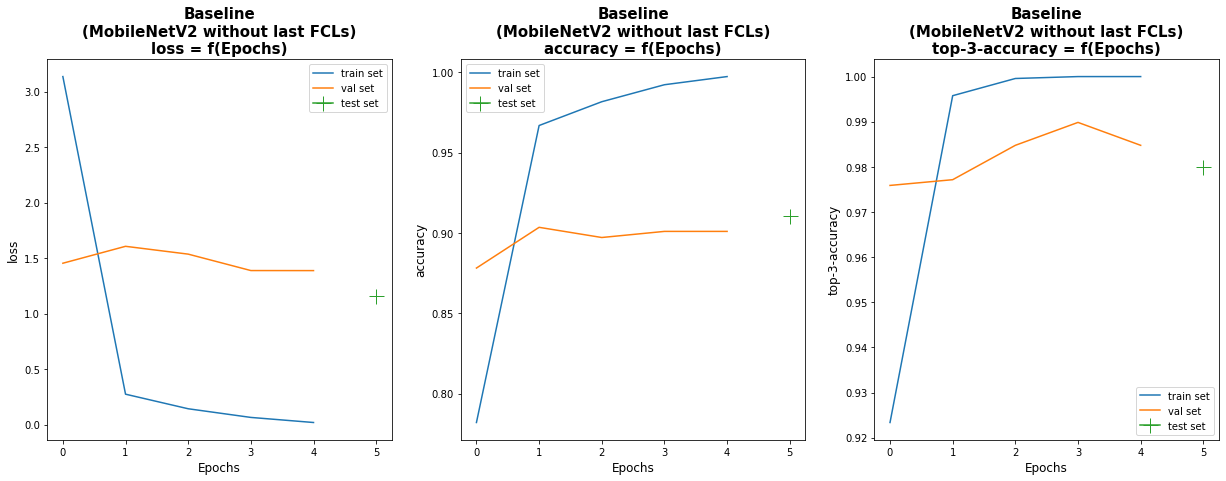

In [31]:
baseline_eval, tps_test_baseline = plot_loss_score(
    baseline_info, load_model(path_cache_output+'02_baseline_best.h5'), [test_ds_bas], [''], 'Baseline\n(MobileNetV2 without last FCLs)'
)
if sauvegarde_figure :
    plt.savefig(path_fig+'02_baseline_plot_scores.png')

#### <u><b>c) Sauvegardes des performances dans un dictionnaire</b></u>
On affiche le .summary() pour accéder au nombre de paramètres entraînables de la baseline

In [32]:
baseline.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [37]:
if dossiers_b2d_chiens == "150_dogs_per_race/":
    baseline_train_param = 815373
else :
    baseline_train_param = 1756188

In [38]:
# sauvegarde effective
dict_model(baseline_info, tps_train_baseline, baseline_eval, tps_test_baseline, baseline_train_param, '02_baseline_dict')

# <u><b>III - Comparaisons des performances du modèle issu de Vit avec celles de la baseline</b></u>

In [39]:
# Liste des noms sous lesquels sont enregistrés les modèles
tab_model = ['01_vit', '02_baseline']
# Liste des dictionnaires de performances correspondant
tab_dict = [
    pickle_load(suffix_title=name+'_dict') for name in tab_model
]

Notons que pour les performances temporelles, on tient compte des différences de nombre de poids à re-apprendre lors des phases d'entraînement/validation

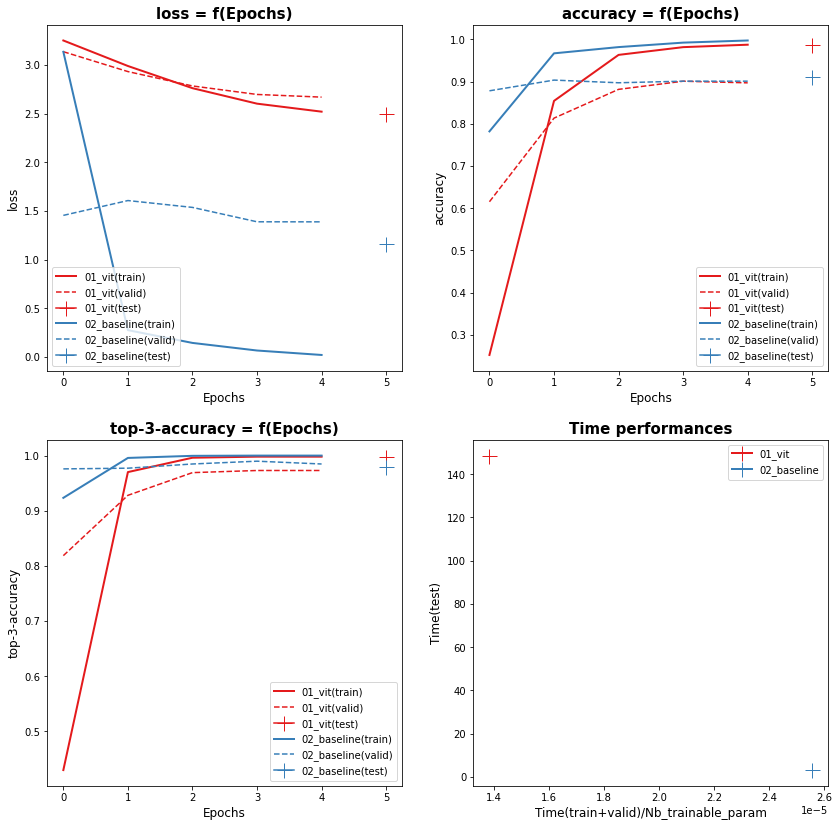

In [40]:
plt.figure('Comparaisons performances', figsize=(14,14)), plt.clf()
for h, m in enumerate(baseline_info.model.metrics_names):
    axe = plt.subplot(2, 2, h+1)
    axe.set_title(m+' = f(Epochs)', fontsize=15, fontweight='bold'), axe.set_ylabel(m, fontsize=12), axe.set_xlabel('Epochs', fontsize=12)
    for i, (name, dic) in enumerate(zip(tab_model, tab_dict)) :
        c = cm.Set1(i)
        axe.plot(dic[m], linewidth=2, label=name+'(train)', color=c)
        axe.plot(dic['val_'+m], linestyle='--', label=name+'(valid)', color=c)
        axe.plot([len(dic[m])], [dic['test_'+m]], label=name+'(test)', color=c, marker='+', markersize=15)
    axe.legend(loc='best')
# Performance temporelle = f(epochs)
axe = plt.subplot(2, 2, 4)
axe.set_title('Time performances', fontsize=15, fontweight='bold'), axe.set_ylabel('Time(test)', fontsize=12), axe.set_xlabel('Time(train+valid)/Nb_trainable_param', fontsize=12)
for i, (name, dic) in enumerate(zip(tab_model, tab_dict)) :
    c = cm.Set1(i)
    nb_param = dic['nb_train_param']
    axe.plot([dic['train_time']/nb_param], [dic['test_time']], linewidth=2, label=name, color=c, marker='+', markersize=15)
# Legends
axe.legend(loc='best')
if sauvegarde_figure:
    plt.savefig(path_fig+'03_comparaison_modeles.png')
del h, m, axe, i, name, dic, c, nb_param